# Demo semantic segmentation
### Recognize roof materials
Stian Teien  
Spring 2022  
Master thesis  
_____________________________________________________________________________________

## Import all moduls and connect to google drive to load the data 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Mounted at /content/gdrive
/content/gdrive/MyDrive/M_DV_V2022


In [2]:
!pip install segmentation-models --quiet
!pip install mycolorpy --quiet
!pip install tensorflow-addons --quiet

     |████████████████████████████████| 50 kB 7.9 MB/s 
     |████████████████████████████████| 1.1 MB 29.9 MB/s 


In [3]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models.losses import CategoricalFocalLoss
from segmentation_models.losses import JaccardLoss

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp

from keras.layers import Input
from keras.callbacks import EarlyStopping
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import backend as K

from keras.layers import Input, Conv2D
from keras.models import Model

from unet_detection.models.vanilla_unet import vanilla_unet

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


## Load data

In [4]:
X_train_raw = np.load("data/spec_lib/X_data.npy") 
y_train_raw = np.load("data/spec_lib/y_data.npy")

X_test_raw = np.load("data/spec_lib/X_data_test.npy")
y_test_raw = np.load("data/spec_lib/y_data_test.npy")

## Train / validation - split
Function for spliting 

In [5]:
def train_val_split(X, y, val_split=0.2, idx=None):
  # Check if possible to stride
  assert np.unique(y).shape[0] == 11, "not enough unique values in set to stride" # n classes / Kanskje ta med det?

  # Do it
  dist = []
  for y_ in y:
    a = list(np.unique(y_, return_counts=True))
    for i in range(11):
      if i not in a[0]:
        a[0] = np.append(a[0], i)
        a[1] = np.append(a[1], 0)

    a[0], a[1] = zip(*sorted(zip(a[0], a[1])))
    dist.append(a)

  dist = np.array(dist, dtype=object)
  data_length = np.array([i for i in range(X.shape[0])])
  val_split = int(X.shape[0]*val_split)

  switch_test = False
  if idx is None:
    for _ in range(100):
      idx = np.random.choice(data_length, replace=False, size=val_split)
      e = np.sum(dist[idx], axis=0)[1]
      test = np.any((e == 0))
      if not test:
        print(test, e, idx)
        # ok in test set?
        switch_test = True
        break
    
    assert switch_test == True, "Not found any good strides"
  X_val = X[idx]
  y_val = y[idx]

  not_idx = np.array(data_length[list(set(range(X.shape[0])) - set(idx))])
  X_train = X[not_idx]
  y_train = y[not_idx]

  a = np.unique(y_val ,return_counts=True)[1]
  b = np.unique(y_train ,return_counts=True)[1]
  try: 
    c = np.abs(a/np.sum(a) - b/np.sum(b))
  except:
    c = np.array([1,1])

  test_distrubtion = (c < 0.01).all()
  print(c)
  

  return X_train, X_val, y_train, y_val, test_distrubtion

In [6]:
X_train, X_val, y_train, y_val, t = train_val_split(X_train_raw, y_train_raw, val_split=0.2,
                                                    idx=np.array([94, 26, 69, 34 ,75, 83, 5, 40 , 7, 60 , 8, 20, 92, 55, 78, 85, 63, 65 ,80]))

[0.00187636 0.00686426 0.00647528 0.00963287 0.0039017  0.005261
 0.00908493 0.00473175 0.00108315 0.00122083 0.00335385]


### Show distrubtion for train and validation set

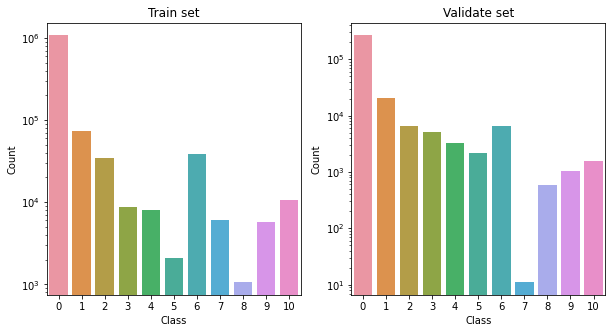

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.reset_orig()

for ax, y, title in [(ax1, y_train, "Train set"), (ax2, y_val, "Validate set")]:
  dist = np.array(np.unique(y, return_counts=True))
  a = pd.DataFrame(dist.T, columns = ["Class", "Count"])
  a["label"] = ["None", "unknown", "black concrete", "metal roofing", "black ceramic", "brown concrete", 
            "red concrete", "gravel", "green ceramic", "pcv", "tar roofing paper"]
  sns.reset_orig()
  g= sns.barplot(data=a, x="Class", y="Count", ax=ax)
  ax.set_title(title)
  g.set_yscale("log")

## Scale X data
The data is originally in a int16 datatype. That means it ranges from -32767 to 32767. I want to scale this from 0 to 1.

In [8]:
X_test = X_test_raw.copy()

maksen = 32767
X_train[X_train>maksen] = maksen
X_val[X_val>maksen] = maksen
X_test[X_test>maksen] = maksen

X_train /= maksen
X_val /= maksen
X_test /= maksen

X_train = abs(X_train)
X_val = abs(X_val)
X_test = abs(X_test)

## Redesign y data
The y data is in a stratified version. I want it to be in a onehot-type. Therefore the classes is not 0 to 11, but the index of the vector indicate the class.  
[0 1 2] &#8594; &#8594; [[1 0 0] [0 1 0] [0 0 1]]  
(99, 128,128, 1)  &#8594;  &#8594; (99, 128, 128, 11)

In [9]:
def redesign_y(y):
  y = y.reshape((y.shape[0],y.shape[1], y.shape[2], 1))
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [10]:
y_train = redesign_y(y_train).astype(np.float32)
y_val = redesign_y(y_val).astype(np.float32)
y_test = redesign_y(y_test_raw).astype(np.float32)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(77, 128, 128, 11)
(19, 128, 128, 11)
(24, 128, 128, 11)


## Make data tensors with tf.data
For faster computation

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_dataset
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

# Model - Set up and Training

## Set up metrics
MCC

In [12]:
def multi_mcc(y_true, y_pred, false_pos_penal=1.0):
    # Reshape image to flatten form
    y_true = K.reshape(y_true, [-1, 11])#y_true.shape[-1]])
    y_pred = K.reshape(y_pred, [-1, 11])#y_pred.shape[-1]])

    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.linalg.band_part(confusion_m, 0, 0) + tf.linalg.band_part(confusion_m, 0, -1)*false_pos_penal + tf.linalg.band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    up = N*tf.linalg.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m))) 
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    return K.mean(mcc)

## Set up loss function

In [13]:
c_loss = CategoricalFocalLoss()
j_loss = JaccardLoss(class_weights=np.array([1,1,1,1,1,1,1,1,1,1,1]))
loss =  c_loss + 1*j_loss

## Set up model and compile

In [14]:
model = sm.Unet(backbone_name='resnet34',
                encoder_weights=None, input_shape=(128, 128, X_train.shape[-1]),
                classes=11, activation='softmax')

model.compile(optimizer='adam',
                loss=loss,
                metrics=[multi_mcc])

### Train model

In [15]:
h = model.fit(train_ds,
            validation_data=(X_val, y_val),
            epochs=300, verbose=2)

Epoch 1/300
3/3 - 29s - loss: 1.0394 - multi_mcc: 0.0096 - val_loss: 1.3576 - val_multi_mcc: 0.0023 - 29s/epoch - 10s/step
Epoch 2/300
3/3 - 2s - loss: 1.0227 - multi_mcc: 0.0218 - val_loss: 1.3552 - val_multi_mcc: -2.4073e-03 - 2s/epoch - 768ms/step
Epoch 3/300
3/3 - 2s - loss: 1.0103 - multi_mcc: 0.0354 - val_loss: 1.3528 - val_multi_mcc: 0.0017 - 2s/epoch - 720ms/step
Epoch 4/300
3/3 - 2s - loss: 0.9965 - multi_mcc: 0.0547 - val_loss: 1.3556 - val_multi_mcc: -2.2334e-04 - 2s/epoch - 720ms/step
Epoch 5/300
3/3 - 2s - loss: 0.9842 - multi_mcc: 0.0764 - val_loss: 1.3561 - val_multi_mcc: -3.8723e-04 - 2s/epoch - 722ms/step
Epoch 6/300
3/3 - 2s - loss: 0.9705 - multi_mcc: 0.0976 - val_loss: 1.3521 - val_multi_mcc: -1.1543e-03 - 2s/epoch - 722ms/step
Epoch 7/300
3/3 - 2s - loss: 0.9549 - multi_mcc: 0.1313 - val_loss: 1.3505 - val_multi_mcc: 0.0013 - 2s/epoch - 718ms/step
Epoch 8/300
3/3 - 2s - loss: 0.9413 - multi_mcc: 0.1490 - val_loss: 1.3431 - val_multi_mcc: 0.0101 - 2s/epoch - 709ms/s

# Evaluate model

## Metric

Text(0.5, 1.0, 'scorings')

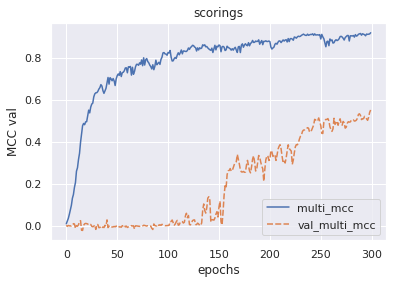

In [16]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][:]) for key in ['multi_mcc','val_multi_mcc']})
plt.xlabel("epochs"); plt.ylabel("MCC val")
plt.title("scorings")

## Visiual

In [17]:
rød = X_test[:,:,:,81]; grønn = X_test[:,:,:,46]; blå = X_test[:,:,:,21];
rgb = [np.dstack((r,g,b)) for r,g,b in zip(rød,grønn,blå)]
rgb = np.array(rgb)

nx = 6
ny = 2

def arange_image(img, nx=6, ny=2, o=0):
  u = []
  o = o
  for i in range(int(nx)):
    b = np.array(img[o])
    o += 1
    for j in range(1,int(ny)):
      b = np.append(b, img[o], axis=1)
      o += 1
                  
    if len(u) == 0:
      u = b
    else:
      u = np.append(u, b, axis=0)
  return u


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


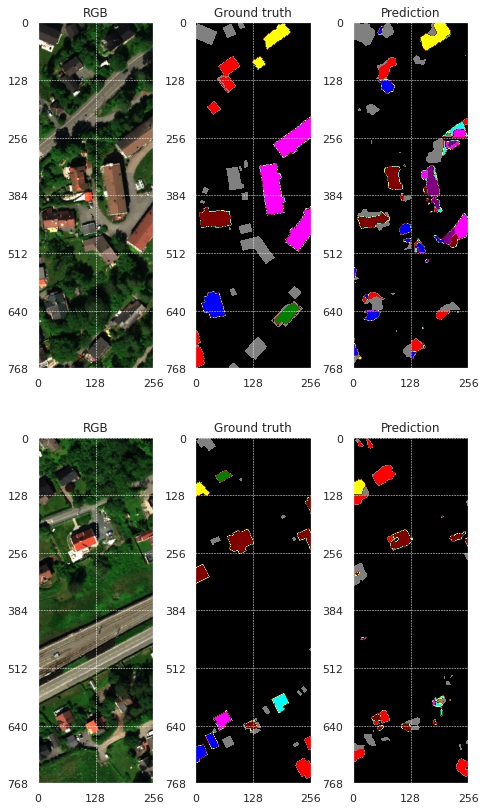

In [18]:
classes = ["None", "Unknown", "black concrete", "metal roofing", "black ceramic", "brown concrete", 
           "red concrete", "gravel", "green ceramic", "pcv", "tar roofing paper"]

colormap = ListedColormap(["black", "gray", "red", "green", "yellow", "cyan", "maroon",
                           "magenta", "seagreen", "purple", "blue"])

y = y_test.argmax(axis=3)

def set_grid(ax, ny=2, nx=6):
  ax.set_yticks([j*128 for j in range(0,nx+1)])
  ax.set_xticks([j*128 for j in range(0,ny+1)])
  ax.grid(color='w', linestyle='--', linewidth=0.5)

#sns.set_context(rc={"lines.linewidth": 128})
for name in ["test"]:
  #model = make_model()
  #model.load_weights(name)
  pred = model.predict(X_test)
  p = np.argmax(pred,axis=3)

  u1,u2 = arange_image(rgb, ny=2, o=0), arange_image(rgb, o=12)
  v1,v2 = arange_image(y,  o=0), arange_image(y,o=12)
  w1,w2 = arange_image(p, o=0), arange_image(p,  o=12)

  w1[0:11, 0] = [0,1,2,3,4,5,6,7,8,9,10]
  w2[0:11, 0] = [0,1,2,3,4,5,6,7,8,9,10]
  v1[0:11, 0] = [0,1,2,3,4,5,6,7,8,9,10]
  v2[0:11, 0] = [0,1,2,3,4,5,6,7,8,9,10]

  #sns.reset_orig()
  fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,14))

  for ax,bilde in [(axs[0,0],u1),(axs[1,0],u2)]:
    ax.imshow(bilde*10); ax.set_title("RGB")
    set_grid(ax)

  for ax,bilde in [(axs[0,1],v1),(axs[1,1],v2)]:
    ax.imshow(bilde, cmap=colormap); ax.set_title("Ground truth")
    set_grid(ax)

  for ax,bilde in [(axs[0,2],w1),(axs[1,2],w2)]:
    im = ax.imshow(bilde, cmap=colormap); ax.set_title("Prediction")
    set_grid(ax)


  #cbar = plt.colorbar(im, cmap=colormap)
  #n_clusters = 11
  #tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
  #cbar.set_ticks(tick_locs)
  # set tick labels (as before)
  #cbar.set_ticklabels(classes)

  plt.show()


## Confussion matrix

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_tot = model.predict(X_val)

Text(0.5, 1.0, 'Confussion matrix - materials')

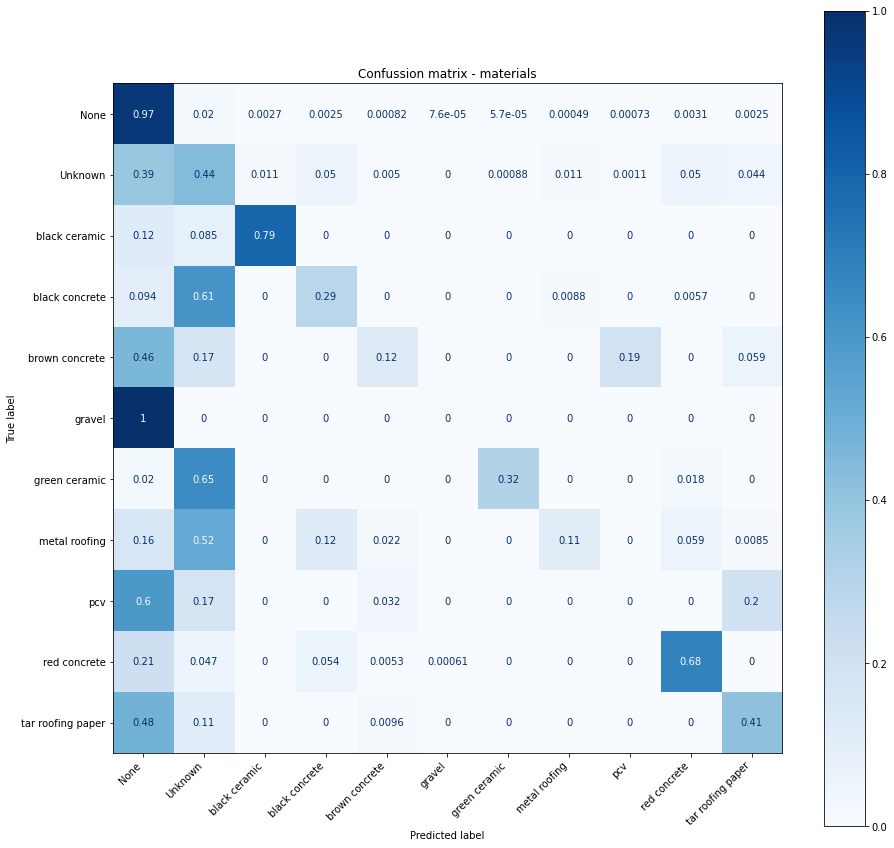

In [20]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(15, 15))

ticks = np.array(classes)
true = ticks[y_val.argmax(axis=3).flatten()]
pre = ticks[pred_tot.argmax(axis=3).flatten()]


disp = ConfusionMatrixDisplay.from_predictions(true, pre,
                                        labels=np.unique(ticks),
                                        cmap=plt.cm.Blues,
                                        xticks_rotation=45,
                                        ax=ax,
                                        normalize="true")
ax.set_xticklabels(ax.get_xticklabels() ,ha="right")
plt.title("Confussion matrix - materials")

## Metric - binary
Roof or not roofs

In [27]:
binary_pred = pred_tot.copy().argmax(axis=3)
binary_y_val = y_val.copy().argmax(axis=3)

In [32]:
binary_pred[binary_pred > 0] = 1
binary_y_val[binary_y_val > 0] = 1

Text(0.5, 1.0, 'Confussion matrix - materials')

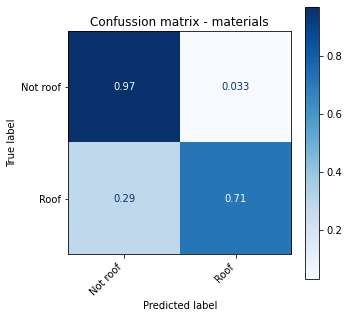

In [35]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(5, 5))

classes = ["Not roof", "Roof"]
ticks = np.array(classes)
true = ticks[binary_y_val.flatten()]
pre = ticks[binary_pred.flatten()]


disp = ConfusionMatrixDisplay.from_predictions(true, pre,
                                        labels=np.unique(ticks),
                                        cmap=plt.cm.Blues,
                                        xticks_rotation=45,
                                        ax=ax,
                                        normalize="true")
ax.set_xticklabels(ax.get_xticklabels() ,ha="right")
plt.title("Confussion matrix - materials")